In [1]:
import pandas as pd
import numpy as np
from pydataset import data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, f_regression

import warnings
warnings.filterwarnings("ignore")

from telco_pipeline import get_data_from_sql, peekatdata, split, df_value_counts, percent_missing, clean_data, encode, scale_minmax

### Project Planning and Checklist

- What are the profiles of the customers who are churning? In presentation

- How do you deal with the column that converts monthly tenure to annual?

- Don't just identify that people leave bc they can, but what are the drivers that make them leave?

- Answer questions in exploration and analysis stages. Add comments and notes in notebook about why you're doing what you're doing and what your conclusions are.

- Don't deliver the data without your assessment of what is going on even if you add "I would need to assess this, but..."

- This "leader" wants to know all of the data behind our assessments. A diagram of the work flow and what you did is great.

- How likely is your model to accurately predict churn, return False positives and false negatives?

- Your .py files do NOT have to be exactly the ones and names of what is laid out in the project.

- If you transform data in a column, then you need to explain why you did that. ie. if you scale data, why did you do that?

- Add context (text) to numbers that make them meaningful.

- Include Google slide summarizing your model with links in your README.

- Project Planning from project outline would be good for the structure of your README file. ie. - data dictionary.

- Make a task list that lays out what you need to do at each stage of the pipeline. This could look like headers in your notebook.

- Exploration is when you would to do your t-tests, chi-squared tests.

- Train multiple models, different algorithms, but also change hyperparameters for the same model. ie. - k=2, k=3, k=4, diff features in same algorithm.

- You can decide what your cutoff point will be when deciding what the probability should be to predict churn or not churn at the end.

- Baseline #1 is proportion of churn to not churn. Find this rate first! It needs to be better than 60% accurate.

- Baseline #2 is doing minimal prep and running it through a model. 

- Model #3 is your MVP. Explore and answer the required questions. Prepare data to go into other algorithms (encoding or scaling as needed). Some automated feature selection here, too. Make predictions on this data

- Other Modeling - to gain more insight but beyond simple answers of basic questions. This would be where you include extra feature engineering. 

### Acquistion

- Here I used my function to bring in data using a sql query.
    
- My query brought over everything from all of the tables together,
    so I could look at the data before deciding how to clean and process.

In [2]:
df = get_data_from_sql()

### Data Prep

- I created a function that returns important info on the dataframe.

In [3]:
peekatdata(df)

DataFrame Shape:

(7043, 24)

Info about:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7043 non-null int64
internet_service_type_id    7043 non-null int64
contract_type_id            7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing     

- I created and used a function to decide whether to bin data for the value counts.

- I'm not worried about customer_id's unique counts because each is unique, and I will end up converting it to be the index before running it through a model. I need the customer_id to create a csv file later, so I will save it by converting it.

- That leaves tenure, monthly_charges, and total_charges with a large number of unique values which may benefit from binning.

In [4]:
df = df.set_index("customer_id")
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
customer_id,,,,,,,,,,,,,,,,,,,,,
0003-MKNFE,2,1,1,Male,0,No,No,9,Yes,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
0013-MHZWF,4,1,1,Female,0,No,Yes,9,Yes,No,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
0015-UOCOJ,1,1,1,Female,1,No,No,7,Yes,No,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
0023-HGHWL,1,1,1,Male,1,No,No,1,No,No phone service,...,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
0032-PGELS,3,1,1,Female,0,Yes,Yes,1,No,No phone service,...,No,No,No,No,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [5]:
valcount_df = df_value_counts(df)
valcount_df

,0
payment_type_id,4
internet_service_type_id,3
contract_type_id,3
gender,2
senior_citizen,2
partner,2
dependents,2
tenure,73
phone_service,2
multiple_lines,3


- I want to decide if and which rows or columns should be dropped.

- Running .value_counts() on total charges column showed me it has 11 values that are blank space. These are most likely for customers who have not had the service long enough to have a total_charge.

- Considering these findings, I will create and run a function that replaces the blank values with NaN and returns the percent of missing values in each column in order to make my final decision about dropping rows that contain NaNs.

- I'm including in this function a line to drop customer_id as I will not be needing this column.

In [6]:
df["total_charges"].value_counts(dropna=False)

           11
20.2       11
19.75       9
19.65       8
19.9        8
20.05       8
19.55       7
45.3        7
20.15       6
19.45       6
20.25       6
20.3        5
20.45       5
49.9        4
75.3        4
69.9        4
70.6        4
19.4        4
20.5        4
19.95       4
69.95       4
19.5        4
19.3        4
20.4        4
69.6        4
44          4
69.65       4
50.15       4
19.85       4
44.4        4
74.7        4
20.35       4
19.2        4
44.75       3
45.85       3
20.1        3
50.75       3
35.9        3
24.4        3
470.2       3
45.1        3
2317.1      3
85.5        3
50.6        3
74.6        3
86.05       3
74.3        3
50.45       3
70.3        3
80.55       3
70.45       3
24.8        3
74.9        3
19.25       3
20.9        3
305.55      3
45.7        3
19.1        3
55.7        3
20.55       3
75.35       3
1284.2      3
74.35       3
220.45      3
69.25       3
85          3
383.65      3
69.1        3
20          3
25.25       3
79.55       3
70.15 

- This percent_missing function below reveals that only total_charges has missing values, and the percent of missing values is .16%.

- This confirms my decision to drop the rows with NaNs.


In [7]:
percent_missing(df)

payment_type_id             0.000000
internet_service_type_id    0.000000
contract_type_id            0.000000
gender                      0.000000
senior_citizen              0.000000
partner                     0.000000
dependents                  0.000000
tenure                      0.000000
phone_service               0.000000
multiple_lines              0.000000
online_security             0.000000
online_backup               0.000000
device_protection           0.000000
tech_support                0.000000
streaming_tv                0.000000
streaming_movies            0.000000
paperless_billing           0.000000
monthly_charges             0.000000
total_charges               0.156183
churn                       0.000000
contract_type               0.000000
internet_service_type       0.000000
payment_type                0.000000
dtype: float64

- Here I am running my function clean_data to replace empty space values in total_charges with NaN, dropping the rows with Nan, dropping customer_id and confirming the drop with an .isnull().sum().

In [8]:
df = clean_data(df)
df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

- Here I will transform dataframe values from "Yes" and "No"/"No phone service"/"No internet service" to True/False, so it is more intuitive to understand during exploration and interpretation.

- Female/Male will be denoted in the "gender" column by binary ints.

In [9]:
df.replace(to_replace=['No', 'Yes'], value=[False, True], inplace=True)
df.replace(to_replace=['No phone service'], value=[False], inplace=True)
df.replace(to_replace=['Female', 'Male'], value=[1, 0], inplace=True)
df.replace(to_replace=['No internet service'], value=[False], inplace=True)
df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
gender                        int64
senior_citizen                int64
partner                        bool
dependents                     bool
tenure                        int64
phone_service                  bool
multiple_lines                 bool
online_security                bool
online_backup                  bool
device_protection              bool
tech_support                   bool
streaming_tv                   bool
streaming_movies               bool
paperless_billing              bool
monthly_charges             float64
total_charges               float64
churn                          bool
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

- Here I compute a new feature comleted_years translating tenure from months to years. 

- I want to use this later to look at month-to-month and 1-year contract customers.


In [10]:
df["completed_years"] = round(df["tenure"] / 12)
df["completed_years"].value_counts().sort_index()

0.0    1470
1.0    1156
2.0    1004
3.0     715
4.0     868
5.0     786
6.0    1033
Name: completed_years, dtype: int64

- I decided not to create a new column phone_id that captures phone_service and multiple_lines into a single int variable. I want to keep this information separate.


- Here I added a new column "family" that combines "dependents" and "partner" and is True for either having dependents or family or False for having neither.

Data Dictionary:

- True - partner or dependents


- False - neither partner or dependents

In [11]:
df['family'] = (df.partner == True) | (df.dependents == True)

- Here I added a new column streaming_services of dtype bool that combines streaming_movies and streaming_tv into one. If the customer has either of these, the value is True. 

- I decided to combine these based on the results of my heat map in exploration. These two variables are highly correlated with each other.


Data Dictionary:

- True - partner or dependents


- False - neither partner or dependents

In [12]:
df["streaming_services"] = (df.streaming_movies == True) | (df.streaming_tv == True)
df["streaming_services"].value_counts()

False    3537
True     3495
Name: streaming_services, dtype: int64

- Here I added a column online_services of dtype int that combines online_security, online_backup, device_protection, and tech_support and is dtype int.

Data Dictionary: 
    
- 0 = False


- 1 = True

In [13]:
df["online_services"] = df.online_security + df.online_backup + df.device_protection + df.tech_support
df["online_services"].value_counts()

True     4245
False    2787
Name: online_services, dtype: int64

- Here I am dropping columns I used to create the new, merged columns above because I don't need them with the new columns.

In [14]:
df = df.drop(columns=["streaming_tv", "streaming_movies", "contract_type", "internet_service_type", "payment_type", "payment_type_id", "paperless_billing", "online_security", "online_backup", "device_protection", "tech_support", "partner", "dependents"])

In [15]:
df.dtypes

internet_service_type_id      int64
contract_type_id              int64
gender                        int64
senior_citizen                int64
tenure                        int64
phone_service                  bool
multiple_lines                 bool
monthly_charges             float64
total_charges               float64
churn                          bool
completed_years             float64
family                         bool
streaming_services             bool
online_services                bool
dtype: object

In [16]:
df.shape

(7032, 14)

- Here I am ready to split the data 70/30 train/test using my split function.


In [17]:
train, test = split(df=df, target="churn", train_prop=.70, seed=123)

train.head()
test.shape

(2110, 14)

#### Encode columns:

- I'm going to run my encode function on the columns internet_service_type_id and contract_type_id, so that I have the versatility to run those variables through multiple models.


- After I create the new encoded columns, I will rename the new columns to reflect what they denote.

In [18]:
train, test, int_encoder, ohe = encode(train, test, "internet_service_type_id")

In [19]:
train.rename(columns={1 : "dsl", 2 : "fiber", 3 : "none"}, inplace = True)
test.rename(columns={1 : "dsl", 2 : "fiber", 3 : "none"}, inplace = True)

In [20]:
train, test, int_encoder, ohe = encode(train, test, "contract_type_id")

In [21]:
train.rename(columns={1 : "monthly", 2 : "1-year", 3 : "2-year"}, inplace = True)
test.rename(columns={1 : "monthly", 2 : "1-year", 3 : "2-year"}, inplace = True)

- Here I'm peeking at my renamed columns to confirm changes.

In [22]:
train.head()

,internet_service_type_id,contract_type_id,gender,senior_citizen,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,completed_years,family,streaming_services,online_services,dsl,fiber,none,monthly,1-year,2-year
customer_id,,,,,,,,,,,,,,,,,,,,
8439-LTUGF,3,1,0,0,10,True,False,20.00,198.60,False,1.0,False,False,False,0.0,0.0,1.0,1.0,0.0,0.0
5339-PXDVH,2,1,0,0,4,True,True,90.65,367.95,False,0.0,False,True,True,0.0,1.0,0.0,1.0,0.0,0.0
9068-FHQHD,3,3,1,0,40,True,False,20.15,777.35,False,3.0,True,False,False,0.0,0.0,1.0,0.0,0.0,1.0
9475-NNDGC,2,2,0,0,71,True,True,113.15,7953.25,False,6.0,True,True,True,0.0,1.0,0.0,0.0,1.0,0.0
7268-IGMFD,2,1,0,1,18,True,True,93.90,1743.90,False,2.0,False,True,True,0.0,1.0,0.0,1.0,0.0,0.0


### Create x and y variables for exploration and modeling

In [23]:
y_train = train[["churn"]]
y_test = test[["churn"]]
y_test.shape

(2110, 1)

In [24]:
x_train = train.drop(columns="churn")
x_test = test.drop(columns="churn")
x_test.shape

(2110, 19)

- I will run my first model without scaling and return to this step for my MVP below.


### Data Exploration

#### A look at the distribution of overall total churn

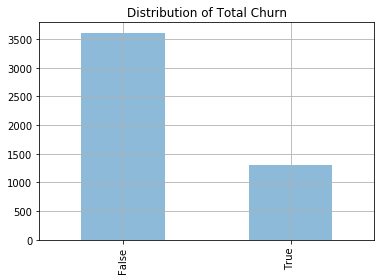

In [25]:
train.churn.value_counts().sort_index().plot(kind = "bar",alpha = .5)
plt.title("Distribution of Total Churn")
plt.grid(b = True , which = "major")

- I created visualizations exploring interactions of variables (independent with independent and independent with dependent). My goal was to identify features that are related to churn, identify integrity issues, understand how the data works.


- A ran a heatmap to explore correlations between independent variables and dependent target variable and independent variables with each other.

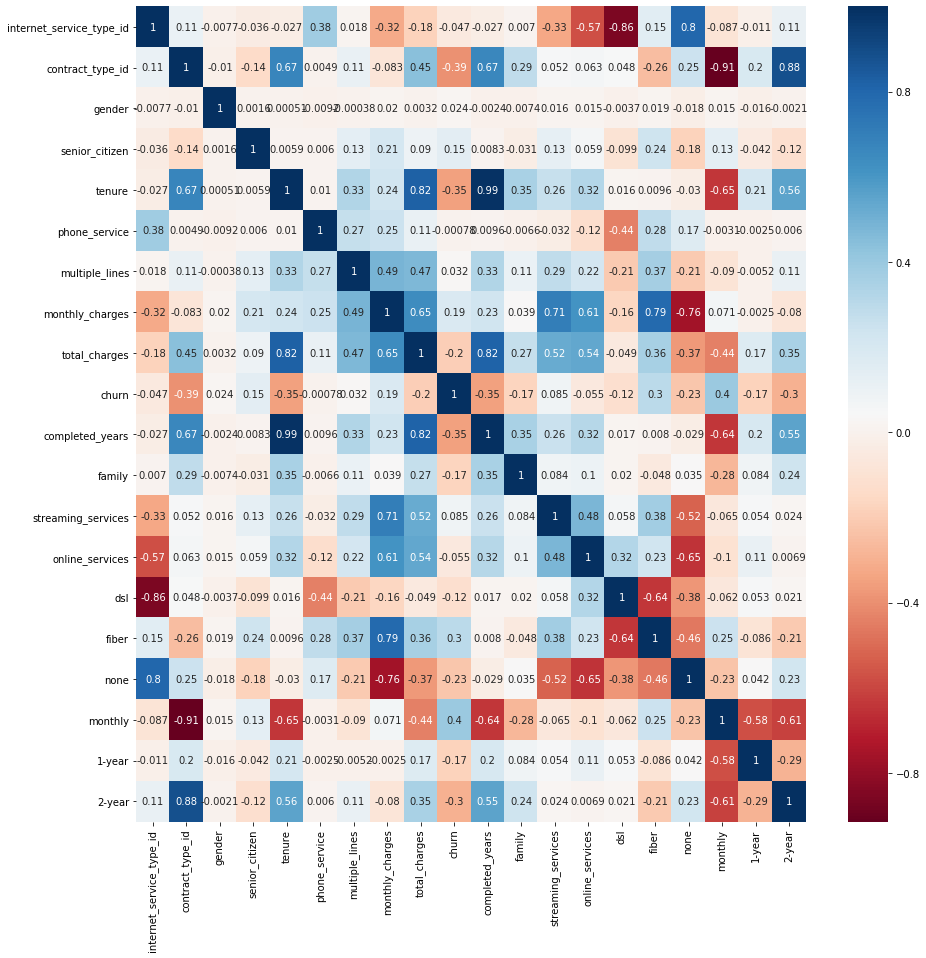

In [26]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), cmap='RdBu', annot=True)

#### Are there features that indicate higher propensity to churn?

According to the correlation figures on the heatmap, monthly (40%), completed_years (35%), 2-year contracts (30%), and total_charges (.20) have the highest correlations with the target of churn. Monthly_charges (19%), family (17%), and senior_citizen (15%) variables have lesser correlations, but they are high enough to remain of interest as features that could add some predictive accuracy to a model.

#### Could the month they signed up influence churn? 
Here I plot churn on a line chart where x is the completed_years and y is customer churn. We can not pinpoint the month of highest churn from this information, but we can see that there are some interesting peaks and valleys throughout the steady decline over time. These could be areas of interest to investigate in the future.


Text(0.5, 1.0, 'Decline in Churn over Time')

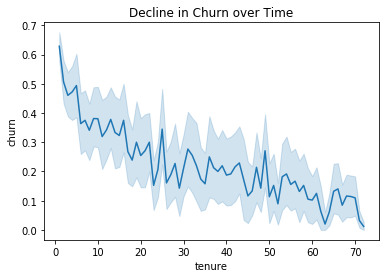

In [27]:
x = train.tenure
y = train.churn
sns.lineplot(x, y)
plt.title("Decline in Churn over Time")

- Here I did a groupby to bin the customers by completed years of tenure to get an idea of the average monthly charges over time.


- The average monthly charge does increase each year, but this is a very high-level view of what is going on with tenure and monthly charges. The average charges only have a range of abouut $21.00, so that's not looking like a driver of churn to me.


- More investigation would have to be done using subsets of services to find out if there is more to the story here. 

In [28]:
avg_monthly_by_year = train.groupby(by="completed_years").monthly_charges.mean()
avg_monthly_by_year

completed_years
0.0    55.596368
1.0    60.084522
2.0    61.091004
3.0    67.140040
4.0    67.717298
5.0    72.346389
6.0    76.021271
Name: monthly_charges, dtype: float64

- Distribution of tenure

- Here I can see the early customer churn that I will control for in the next charts, so I can see what else is in the data.


- There is an interesting jump in tenure between 60 and 70 months. There might be something interesting to investigate about that cohort of customers.

Text(0.5, 1.0, 'Distribution of Tenure')

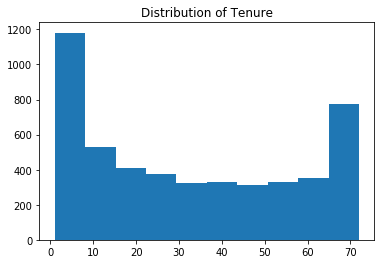

In [29]:
plt.hist(train["tenure"])
plt.title("Distribution of Tenure")

- Here I created a dataframe named "df_tenure_control" to explore the difference in keeping or dropping the customers with one to six months tenure.

In [30]:
months = [1, 2, 3, 4, 5, 6]
df_tenure_control = train.drop(train[train.tenure.isin(months)].index)
df_tenure_control["tenure"].value_counts().sort_index()

7      88
8      88
9      84
10     92
11     72
12     79
13     82
14     57
15     65
16     64
17     56
18     67
19     50
20     55
21     48
22     70
23     59
24     63
25     58
26     56
27     53
28     44
29     42
30     52
31     47
32     47
33     41
34     46
35     57
36     36
37     47
38     45
39     41
40     48
41     47
42     51
43     48
44     29
45     43
46     60
47     42
48     49
49     48
50     44
51     46
52     56
53     44
54     47
55     45
56     54
57     38
58     46
59     38
60     49
61     56
62     47
63     50
64     64
65     53
66     57
67     71
68     69
69     70
70     82
71    124
72    251
Name: tenure, dtype: int64

Text(0.5, 1.0, 'Decline in Churn over Time')

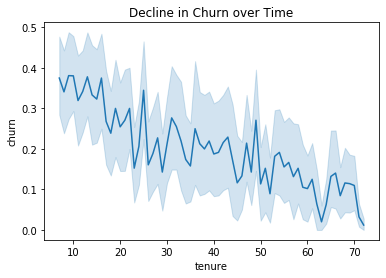

In [31]:
x = df_tenure_control.tenure
y = df_tenure_control.churn
sns.lineplot(x, y)
plt.title("Decline in Churn over Time")

### Exploring data subsets

Data Dictionary:

- Monthly

    -0 = False
    
    
    -1 = True

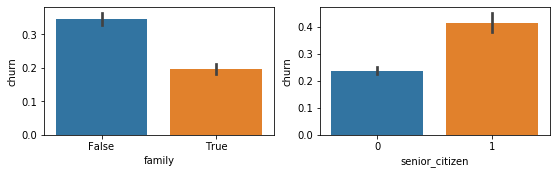

In [32]:
plt.figure(figsize=(14,8))
plt.subplot(3,3,1)
sns.barplot(x="family", y="churn", data=train)
plt.subplot(3,3,2)
sns.barplot(x="senior_citizen", y="churn", data=train)

Data Dictionary:

    -0 = False
    
    -1 = True

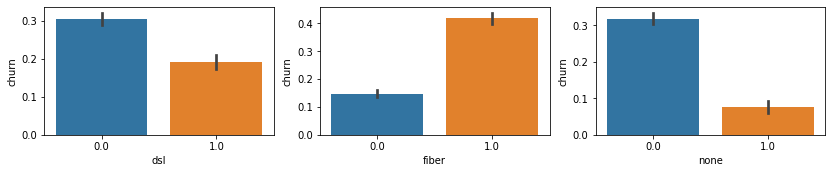

In [33]:
plt.figure(figsize=(14,8))
plt.subplot(3,3,1)
sns.barplot(x="dsl", y="churn", data=train)
plt.subplot(3,3,2)
sns.barplot(x="fiber", y="churn", data=train)
plt.subplot(3,3,3)
sns.barplot(x="none", y="churn", data=train)

Data Dictionary:

- Family

    -True = partner and/or dependents
    
    -False = no partner or dependents
    

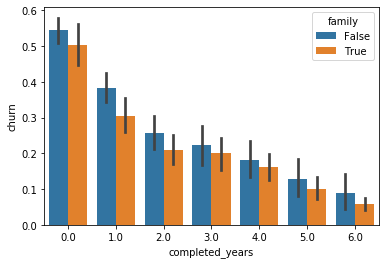

In [34]:
sns.barplot(data=train, x="completed_years", y="churn", hue="family")

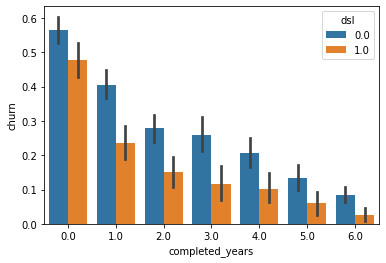

In [35]:
sns.barplot(data=train, x="completed_years", y="churn",hue="dsl")

Data Dictionary:

- DSL

    -0 = False
    
    -1 = True
    
    
- Family

    -True = partner and/or dependents
    
    -False = no partner or dependents

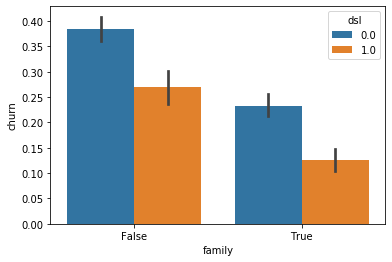

In [36]:
sns.barplot(data=train, x="family", y="churn", hue="dsl")

Data Dictionary:

- DSL

    -0 = False
    
    -1 = True


- Senior citizen

    -0 = False
    
    -1 = True

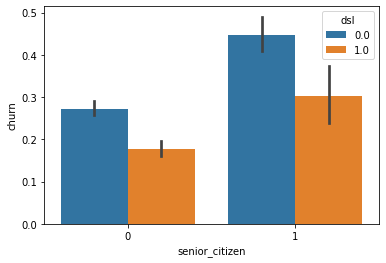

In [37]:

sns.barplot(data=train, x="senior_citizen", y="churn", hue="dsl")

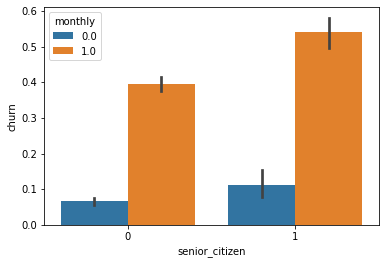

In [38]:
sns.barplot(data=train, x="senior_citizen", y="churn", hue="monthly")

3. Is there a price threshold for specific services where the liklihood of churn increases? What services and at what price point?


- This is yet to be seen on this iteration of this report.

4. Looking at churn rate for month-to-month vs. 1-year contract customers after their 12th month of service, is the rate of churn different?

In [39]:
#train["contract_type_id"].value_counts()
(train.tenure == 12) & (train.contract_type_id == "month_to_month")

customer_id
8439-LTUGF    False
5339-PXDVH    False
9068-FHQHD    False
9475-NNDGC    False
7268-IGMFD    False
6770-UAYGJ    False
9108-EQPNQ    False
8731-WBBMB    False
5195-KPUNQ    False
6408-OTUBZ    False
4393-RYCRE    False
3038-PQIUY    False
3258-SANFR    False
6923-AQONU    False
7560-QJAVJ    False
8763-KIAFH    False
0428-AXXLJ    False
4891-NLUBA    False
4464-JCOLN    False
8992-JQYUN    False
5734-EJKXG    False
4760-XOHVN    False
9154-QDGTH    False
2330-PQGDQ    False
5244-IRFIH    False
4634-JLRJT    False
5863-OOKCL    False
5792-JALQC    False
3131-NWVFJ    False
7130-VTEWQ    False
8328-SKJNO    False
7016-NVRIC    False
4154-AQUGT    False
8450-JOVAH    False
1303-SRDOK    False
4603-JANFB    False
4488-PSYCG    False
3258-ZKPAI    False
2202-CUYXZ    False
7434-SHXLS    False
0440-UEDAI    False
8111-BKVDS    False
6873-UDNLD    False
1194-HVAIF    False
8902-ZEOVF    False
5515-AKOAJ    False
8665-UTDHZ    False
6330-JKLPC    False
7730-CLDSV    False
5774-XZT

5. Use a t-test to find out of the monthly charges of those who have
churned is significantly higher thatn those who have not. Control for:
(phone_id, internet_service_type_id, online_security_backup, device_protection, 
tech_support, and contract_type_id)


- Customers with DSL who have not churned:

In [40]:
no_churn_dsl = train[(train["internet_service_type_id"] == 1) & (train["churn"] == False)]

- Customers with DSL who have churned:

In [41]:
churn_dsl = train[(train["internet_service_type_id"] == 1) & (train["churn"] == True)]

- Customers with Fiber who have not churned:

In [42]:
no_churn_fiber = train[(train["internet_service_type_id"] == 2) & (train["churn"] == False)]

- Customers with DSL who have churned:

In [43]:
churn_fiber = train[(train["internet_service_type_id"] == 2) & (train["churn"] == True)]
type(churn_fiber)

pandas.core.frame.DataFrame

- Calculate mean of monthly_charges for DSL customers who have not churned.

In [44]:
dsl_no_churn_monthly = no_churn_dsl["monthly_charges"].mean()
print(f"The mean of monthly charges for DSL customers who have not churned is: ")
print(dsl_no_churn_monthly)

The mean of monthly charges for DSL customers who have not churned is: 
60.149708454810494


- Calculate mean of monthly_charges for DSL customers who have churned.

In [45]:
dsl_churn_monthly = churn_dsl["monthly_charges"].mean()
print(f"The mean of monthly charges for DSL customers who have churned is: ")
print(dsl_churn_monthly)

The mean of monthly charges for DSL customers who have churned is: 
48.97953846153845


- Calculate mean of monthly_charges for Fiber customers who have not churned.

In [46]:
fiber_no_churn_monthly = no_churn_fiber["monthly_charges"].mean()
print(f"The mean of monthly charges for Fiber customers who have not churned is: ")
print(fiber_no_churn_monthly)

The mean of monthly charges for Fiber customers who have not churned is: 
93.8604299363058


- Calculate mean of monthly_charges for Fiber customers who have churned.

In [47]:
fiber_churn_monthly = churn_fiber["monthly_charges"].mean()
print(f"The mean of monthly charges for Fiber customers who have churned is: ")
print(fiber_churn_monthly)

The mean of monthly charges for Fiber customers who have churned is: 
88.16048834628198


#### Actual T-test

In [48]:
test_results = stats.ttest_ind(no_churn_dsl.monthly_charges, churn_dsl.monthly_charges)
print(f"The test statistic for DSL customers who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: ")
print(test_results[1])

The test statistic for DSL customers who churn vs. those who don't churn is: 11.578298166663087
The p-value of the test is: 
6.844185456987299e-30


In [49]:
test_results = stats.ttest_ind(no_churn_fiber.monthly_charges, churn_fiber.monthly_charges)
print(f"The test statistic for Fiber customers who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: ")
print(test_results[1])

The test statistic for Fiber customers who churn vs. those who don't churn is: 10.584086721880396
The p-value of the test is: 
1.4796197678260636e-25


6. Perform a correlation test, stating hypothesis and conclusion clearly that states if monthly charges can be explained by internet_service_type


$H_0$: The Null Hypothesis is that the monthly charges cannot be explained by internet_service_type.

$H_a$: The Null Hypothesis is that the monthly charges can be explained by internet_service_type.

7. How much of monthly_charges can be explained by internet_service_type + phone service type (0, 1, or multiple lines). State your hypotheses and your conclusion clearly.




$H_0$: The Null Hypothesis is that the monthly charges cannot be explained by internet_service_type + phone_service_type.

$H_a$: The Null Hypothesis is that the monthly charges can be explained by internet_service_type + phone_service_type.

9. What can you say about each variable's relationship to churn, based on your initial exploration? If there appears to be some sort of interaction or correlation, assume there is no causal relationship and brainstorm (and document) ideas on reasons there could be correlation.




### Scale Data Using MinMaxScaler

In [50]:
column_list = ["monthly_charges", "total_charges", "tenure", "completed_years"]
x_train, x_test, scaler = scale_minmax(x_train, x_test, column_list)

In [51]:
x_train.head()
y_train.shape

(4922, 1)

### Use SelectKBest to Explore Feature Selection

In [52]:
f_selector = SelectKBest(f_regression, k=10)

f_selector.fit(x_train, y_train)

f_support = f_selector.get_support()
f_feature = x_train.loc[:,f_support].columns.tolist()

print(str(len(f_feature)), 'selected features')
print(f_feature)

10 selected features
['contract_type_id', 'tenure', 'total_charges', 'completed_years', 'fiber', 'none', 'monthly', '2-year', 'tenure_scaled', 'completed_years_scaled']


### Modeling

#### Feature selection: can you remove any features that provide limited to no additional info?


In [53]:
x_train.drop(columns=["internet_service_type_id", "contract_type_id", "monthly_charges", "total_charges", "tenure", "completed_years", "tenure_scaled"], axis=1, inplace=True)

In [54]:
x_test.drop(columns=["internet_service_type_id", "contract_type_id", "tenure_scaled", "monthly_charges", "total_charges", "tenure", "completed_years"], axis=1, inplace=True)

In [55]:
x_train.columns

Index(['gender', 'senior_citizen', 'phone_service', 'multiple_lines', 'family',
       'streaming_services', 'online_services', 'dsl', 'fiber', 'none',
       'monthly', '1-year', '2-year', 'monthly_charges_scaled',
       'total_charges_scaled', 'completed_years_scaled'],
      dtype='object')

- I tried the below variables based on correlations from the heatmap and findings in Exploration, but the above combination returned the highest results from my models, so I went with those selections.

In [56]:
#x_train = x_train[['fiber', 'none', 'monthly', '2-year', 'completed_years_scaled', 'online_services']]

In [57]:
#x_test = x_test[['fiber', 'none', 'monthly', '2-year', 'completed_years_scaled', 'online_services']]

## Train Baseline Model

### Create the Decision Tree Object

In [58]:

clf = DecisionTreeClassifier(max_depth=7, random_state=123)

### Fit the model to the training data

In [59]:
x_train.shape

(4922, 16)

In [60]:
y_train.shape

(4922, 1)

In [61]:
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

### Estimate Churn

In [62]:
y_pred = clf.predict(x_train)
y_pred.shape

(4922,)

### Estimate the probability of churn

In [63]:
y_pred_proba = clf.predict_proba(x_train)
y_pred_proba.shape

(4922, 2)

## Evaluate Model


In [64]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(x_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.81


## Create a confusion matrix

- True Positive: number of occurrences where y is true and y is predicted true.

- True Negative: number of occurrences where y is false and y is predicted false.

- False Positive: number of occurrences where y is false and y is predicted true.

- False Negative: number of occurrences where y is true and y is predicted false.


In [65]:
cm = pd.DataFrame(confusion_matrix(y_train, y_pred))
cm

,0,1
0,3344,270
1,661,647


### Findings After Running Decision Tree Model with Unscaled Data and a maxdepth of 3

- This confustion matrix tells me that my model is better at predicting True Negatives than True Positives.


- The model predicts at an overall accuracy rate of 78%


- However, the Recall rate for customers who churn is 37% which means that the model is not predicting the positives for churn very well. It is at 93% for predicting the customers who will not churn, so my model is out of balance. 


- I want to be able to better predict the customers who will churn, so we can create personas and more accurately target them with strategies that will keep them from churning.

### Findings After Running Decision Tree with Scaled Data and a max_depth of 7

- The model now predicts at an overall accuracy rate of 81%.


- The True Recall rate for customers who churn has gone up to 49% and stayed at 93% for the False Recall rate. The model is still better at predicting customers who will not churn than those who will. However, it is much improved. I will decide on the best model after I see how the model performs with the test data.

### Create a classification report

- Precision: the higher this number is, the more you were able to pinpoint all positives correctly. If this is a low score, you predicted a lot of positives where there were none. tp / (tp + fp)


- Recall: if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there. tp / (tp + fn)


- f1-score: The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.


- Support: number of occurrences of each class in where y is true.

In [66]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.93      0.88      3614
        True       0.71      0.49      0.58      1308

    accuracy                           0.81      4922
   macro avg       0.77      0.71      0.73      4922
weighted avg       0.80      0.81      0.80      4922



## Train Model 

### Create the Logistic Regression Object

In [67]:
logit = LogisticRegression(random_state = 123, solver='saga')

### Train 

- (fit, transform, evaluate) multiple models and select the best performing model.


In [68]:
logit.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

### Compare eval metrics across all the models and select best performing


- Print the coefficients and intercept of the model


In [69]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[ 0.08038939  0.28686623 -0.89606896  0.22892512 -0.15411953  0.17157096
  -0.52405069 -0.07908435  0.77494864 -0.70468308  0.85249089  0.04535691
  -0.90666659  0.9726041   0.32676668 -2.26570296]]
Intercept: 
 [-0.58988963]


### Estimate whether or not a customer will churn


In [70]:
y_pred = logit.predict(x_train)
y_pred.shape

(4922,)

### Estimate the probability of a customer churning using the train data

In [71]:
y_pred_proba = logit.predict_proba(x_train)
y_pred_proba.shape

(4922, 2)

### Evaluate

- Compute the accuracy


In [72]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(x_train, y_train)))


Accuracy of Logistic Regression classifier on training set: 0.80


### Create a confusion matrix


In [73]:
print(confusion_matrix(y_train, y_pred))

[[3249  365]
 [ 631  677]]


### Compute Precision, Recall, F1-score, and Support

- Precision: the higher this number is, the more you were able to pinpoint all positives correctly. If this is a low score, you predicted a lot of positives where there were none. tp / (tp + fp)


- Recall: if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there. tp / (tp + fn)


- f1-score: The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.


- Support: number of occurrences of each class in where y is true.

In [74]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.90      0.87      3614
        True       0.65      0.52      0.58      1308

    accuracy                           0.80      4922
   macro avg       0.74      0.71      0.72      4922
weighted avg       0.79      0.80      0.79      4922



In [75]:
y_train.shape

(4922, 1)

### Findings After Training Decision Tree Baseline v. Logistic Regression Models with Unscaled Data

- The Logistic Regression model predicts at an overall accuracy rate of 78%


- However, the Recall rate for customers who churn using the Logistic Regression model is 48% as opposed to the 36% Recall rate for the Decision Tree model. It is at 87% for predicting the customers who will not churn, as opposed to the 93% Recall rate for customers who will not churn using the decision tree.


- This LR model DOES better predict the customers who will churn than the Decision Tree model, but I still want to do feature selection and engineering to improve my model's accuracy at predicting suctomer churn.

### Findings After Going Back and Merging Columns and Feature Engineering

- The Logistic Regression model topped out at 80% overall accuracy, but more importantly if sent up from a 36% Recall rate to 52% Recall. I will have to see how this model performs on the test data to decide on the best model.


- I used SelectKBest to find the best combinations of variables to feed in to my model. I used different combinations of features in my train set based on the recommendations, but in the end, my model returned the best results when I handpicked variables based on the correlations I saw in my heatmap in exploration. 

### Decision Tree Model Test 

- Test the final model and evaluate on your out-of-sample data. Summarize the performance, interpret results.


In [76]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(x_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.80


In [77]:
y_pred = clf.predict(x_test)
y_pred.shape

(2110,)

In [78]:
y_pred_proba = clf.predict_proba(x_test)
y_pred_proba.shape

(2110, 2)

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.92      0.87      1549
        True       0.67      0.47      0.55       561

    accuracy                           0.80      2110
   macro avg       0.75      0.69      0.71      2110
weighted avg       0.78      0.80      0.78      2110



### Logistic Classification Model Test

- Test the final model and evaluate on your out-of-sample data. Summarize the performance, interpret results.

In [80]:
y_pred = logit.predict(x_test)
y_pred.shape

(2110,)

In [81]:
y_pred_proba = logit.predict_proba(x_test)
y_pred_proba.shape

(2110, 2)

In [82]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(x_test, y_test)))

Accuracy of Logistic Regression classifier on training set: 0.81


In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.91      0.87      1549
        True       0.68      0.53      0.59       561

    accuracy                           0.81      2110
   macro avg       0.76      0.72      0.73      2110
weighted avg       0.80      0.81      0.80      2110



### The model that returned the best results when run on the test data was the Logistic Regression using the following features to predict:

- gender, senior_citizen, phone_service, multiple_lines, family, streaming_services, online_services, dsl, fiber, none, (all three internet services) monthly, 1-year, 2-year, monthly_charges_scaled, total_charges_scaled, completed_years_scaled


- The model's overall accuracy is at 81%, which is higher than any of the baseline models, coupled with the improved True Recall at 53% and the False Recall at a high 91%.


- The model is still not as high as I would like in the True Recall category, but this is the best rate I have gotten so far. 


- With more time, I think it would be a good idea to look into running models using features based on the results of subsetting data in exploration. 


- I would also like to see the exploration of subsets of data (internet service types, contract types, family structure, age group) lead to creating customer profiles. Customers are not all the same, and they need to be targeted based on needs assessment. 


- I also think that customer surveys would be a good idea in the creation of these profiles. Incentives could be given to fill out and return surveys, so that we could add feedback information to our database.

### Create csv file with customer_id, probability of churn, and prediction of churn

In [84]:
df_concat = pd.concat([x_train, x_test])

In [85]:
df_concat.shape

(7032, 16)

In [88]:
prediction = logit.predict(df_concat)

In [89]:
y_pred_proba = logit.predict_proba(df_concat)

In [95]:
y_predictions = pd.DataFrame({"probability": y_pred_proba[:,1], "predictions": (y_pred_proba[:, 1] >= .5) == 1})

In [96]:
y_predictions.head()

,probability,predictions
0,0.155322,False
1,0.675331,True
2,0.013949,False
3,0.120242,False
4,0.586001,True


In [97]:
y_predictions = y_predictions.set_index(df.index)

In [98]:
y_predictions.head()

,probability,predictions
customer_id,,
0003-MKNFE,0.155322,False
0013-MHZWF,0.675331,True
0015-UOCOJ,0.013949,False
0023-HGHWL,0.120242,False
0032-PGELS,0.586001,True


In [99]:
y_predictions.to_csv(r"probability_and_predictions.csv")

In [102]:
y_predictions["predictions"].sum() / y_predictions["predictions"].count()

0.21075085324232082

In [ ]:
y_predictions["probability"]